### STEP 1: How many adults remain unbanked, and where? (benchmark 2021)

In [296]:
import pandas as pd

# Step 1: Load the Excel file and select the relevant sheet
file_path = "DatabankWide.xlsx"  # Replace with full path if needed
df = pd.read_excel(file_path, sheet_name="Data")

In [297]:
# Step 2: Filter for data from the year 2021
df_2021 = df[df["Year"] == 2021].copy()

In [298]:
# Step 3: Drop rows with missing account ownership data
df_2021 = df_2021.dropna(subset=["Account (% age 15+)"])

In [299]:
# Step 4: Calculate the unbanked percentage
# Formula: Unbanked (%) = 100 - Account (% age 15+)
df_2021["Unbanked (%)"] = 100 - df_2021["Account (% age 15+)"]

In [300]:
# Step 5: Keep only relevant columns for export
df_unbanked = df_2021[["Country code", "Country name", "Unbanked (%)"]]

In [301]:
# Step 6: Save the result in the current directory
output_path = "unbanked_pct_2021.csv"
df_unbanked.to_csv(output_path, index=False)

print("✅ File saved successfully to:", output_path)

✅ File saved successfully to: unbanked_pct_2021.csv


### STEP 2:  Is mobile-money usage rising fast enough to close that gap?

In [302]:
# Step 1: Load the IMF dataset (rename this if you change the file name)
file_path = "dataset_2025-07-28T21_37_55.410137307Z_DEFAULT_INTEGRATION_IMF.STA_FAS_4.0.0.csv"
df = pd.read_csv(file_path)

/var/folders/w2/xzx9cghx6_d87gb1m8mhzgth0000gn/T/ipykernel_68504/2842742436.py:3: DtypeWarning: Columns (15,20,34) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


In [303]:
# Step 2: Filter for mobile money accounts data (e.g. Active accounts)
df_mobile = df[df["INDICATOR"].str.contains("Active mobile money accounts", case=False, na=False)].copy()

In [304]:
# Step 3: Extract country and year columns (2019–2024)
year_cols = [str(y) for y in range(2019, 2025)]
df_mobile_long = df_mobile[["COUNTRY"] + year_cols]

In [305]:
# Step 4: Convert wide format to long format
df_long = df_mobile_long.melt(id_vars="COUNTRY", var_name="Year", value_name="Mobile Money Accounts per 1k Adults")

In [306]:
# Step 5: Drop missing values
df_long_cleaned = df_long.dropna()

In [307]:
# Step 6: Save to CSV in current directory
output_file = "mm_accounts_per_k.csv"
df_long_cleaned.to_csv(output_file, index=False)

In [308]:
print("✅ Mobile money data saved to:", output_file)

✅ Mobile money data saved to: mm_accounts_per_k.csv


### STEP 3: Does economic development still predict who gets included? (GDP per capita)

In [309]:
# Step 1: Load the World Bank GDP per capita file
file_path = "API_NY.GDP.PCAP.CD_DS2_en_csv_v2_122367.csv"
df_gdp = pd.read_csv(file_path, skiprows=4)

In [310]:
# Step 2: Keep only necessary columns (2019–2024 and country info)
columns_to_keep = ["Country Name", "Country Code", "2019", "2020", "2021", "2022", "2023", "2024"]
df_gdp_filtered = df_gdp[columns_to_keep]

In [311]:
# Step 3: Reshape mobile money data to long format (years 2019–2024)
value_vars = [str(i) for i in range(2019, 2025)]  # Include 2024
df_long = df_mobile.melt(
    id_vars=["COUNTRY"],
    value_vars=value_vars,
    var_name="Year",
    value_name="Mobile Money Accounts (Active)"
).dropna()

# Convert Year to integer type
df_long["Year"] = df_long["Year"].astype(int)

# Display the first few rows
df_long.head()

,COUNTRY,Year,Mobile Money Accounts (Active)
0,Indonesia,2019,3.879773e-02
1,Togo,2019,1.899463e+06
2,Senegal,2019,4.034751e+06
4,Samoa,2019,9.037321e-03
5,Botswana,2019,8.423390e+02


In [312]:
# Step 4: Load and merge GDP per capita and unbanked data

# Read GDP per capita dataset
df_gdp = pd.read_csv("gdp_per_capita_2019_2024.csv")

# Read unbanked data for 2021
df_unbanked = pd.read_csv("unbanked_pct_2021.csv")

# Merge mobile money data with GDP data on country and year
df_merged = pd.merge(
    df_long, df_gdp,
    how="left",
    left_on=["COUNTRY", "Year"],
    right_on=["Country Name", "Year"]
)

# Merge with unbanked data (2021)
df_final = pd.merge(
    df_merged, df_unbanked,
    how="left",
    left_on="COUNTRY",
    right_on="Country name"
)

# Drop redundant columns
df_final.drop(columns=["Country Name", "Country name", "Country code"], inplace=True)

# Show a preview of the final merged dataset
df_final.head()

,COUNTRY,Year,Mobile Money Accounts (Active),Country Code,GDP per capita (current US$),Unbanked (%)
0,Indonesia,2019,3.879773e-02,IDN,4106.948562,99.482447
1,Togo,2019,1.899463e+06,TGO,826.260654,99.503944
2,Senegal,2019,4.034751e+06,SEN,1431.181289,99.440356
3,Samoa,2019,9.037321e-03,WSM,4351.942349,NaN
4,Botswana,2019,8.423390e+02,BWA,7172.089565,NaN


In [313]:
# Step 5: Save to CSV in current working directory
output_file = "gdp_per_capita_2019_2024.csv"
df_gdp_cleaned.to_csv(output_file, index=False)

In [314]:
print("✅ GDP per capita data saved to:", output_file)

✅ GDP per capita data saved to: gdp_per_capita_2019_2024.csv


#### STEP 4: Merge mobile money, GDP per capita, and unbanked population data

In [315]:
# Step 1: Load all cleaned datasets
df_gdp = pd.read_csv("gdp_per_capita_2019_2024.csv")
df_mm = pd.read_csv("mm_accounts_per_k.csv")
df_unbanked = pd.read_csv("unbanked_pct_2021.csv")

In [316]:
# Step 2: Merge GDP and mobile money datasets on 'Country Name' and 'Year'
df_mm.rename(columns={"COUNTRY": "Country Name"}, inplace=True)
df_merged = pd.merge(df_mm, df_gdp, on=["Country Name", "Year"], how="inner")

In [317]:
# Step 3: Merge with unbanked data (using 'Country Code' only, fixed for 2021)
df_unbanked.rename(columns={"Country code": "Country Code"}, inplace=True)
df_final = pd.merge(df_merged, df_unbanked, on="Country Code", how="left")

In [318]:
# Step 4: Preview the merged dataset
print(df_final.head())

  Country Name  Year  Mobile Money Accounts per 1k Adults Country Code  \
0    Indonesia  2019                         3.879773e-02          IDN   
1         Togo  2019                         1.899463e+06          TGO   
2      Senegal  2019                         4.034751e+06          SEN   
3        Samoa  2019                         9.037321e-03          WSM   
4     Botswana  2019                         8.423390e+02          BWA   

   GDP per capita (current US$) Country name  Unbanked (%)  
0                   4106.948562    Indonesia     99.482447  
1                    826.260654         Togo     99.503944  
2                   1431.181289      Senegal     99.440356  
3                   4351.942349          NaN           NaN  
4                   7172.089565          NaN           NaN  


In [319]:
# Step 5: Save the final combined dataset to CSV
df_final.to_csv("merged_financial_inclusion_dataset.csv", index=False)
print("✅ Final dataset saved as: merged_financial_inclusion_dataset.csv")

✅ Final dataset saved as: merged_financial_inclusion_dataset.csv


#### STEP 5 – Exploratory Data Analysis (EDA) & Visualization

In [320]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Load the final merged dataset
df = pd.read_csv("merged_financial_inclusion_dataset.csv")

In [321]:
# Step 2: Quick overview
print(df.info())
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 677 entries, 0 to 676
Data columns (total 7 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Country Name                         677 non-null    object 
 1   Year                                 677 non-null    int64  
 2   Mobile Money Accounts per 1k Adults  677 non-null    float64
 3   Country Code                         677 non-null    object 
 4   GDP per capita (current US$)         677 non-null    float64
 5   Country name                         474 non-null    object 
 6   Unbanked (%)                         474 non-null    float64
dtypes: float64(3), int64(1), object(3)
memory usage: 37.2+ KB
None
              Year  Mobile Money Accounts per 1k Adults  \
count   677.000000                         6.770000e+02   
mean   2021.045790                         8.919276e+06   
std       1.447085                         7.720138e+07  

/var/folders/w2/xzx9cghx6_d87gb1m8mhzgth0000gn/T/ipykernel_68504/3570311713.py:23: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Users/ebmac/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


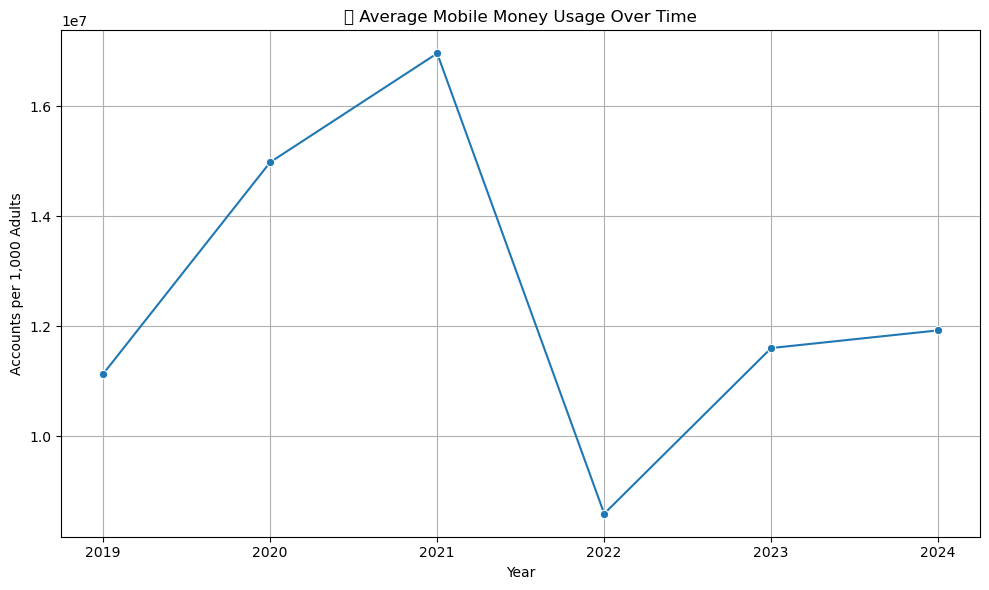

In [322]:
# Step 4: Plot – Average Mobile Money Usage Over Time

# Convert to numeric for plotting
df_plot["Mobile Money Accounts per 1k Adults"] = pd.to_numeric(df_plot["Mobile Money Accounts per 1k Adults"], errors='coerce')

# Remove NaNs
df_plot = df_plot.dropna(subset=["Mobile Money Accounts per 1k Adults"])

# Plot
plt.figure(figsize=(10, 6))
sns.lineplot(
    data=df_plot,
    x="Year",
    y="Mobile Money Accounts per 1k Adults",
    estimator="mean",
    errorbar=None,
    marker="o"
)
plt.title("📈 Average Mobile Money Usage Over Time")
plt.xlabel("Year")
plt.ylabel("Accounts per 1,000 Adults")
plt.grid(True)
plt.tight_layout()
plt.show()

/var/folders/w2/xzx9cghx6_d87gb1m8mhzgth0000gn/T/ipykernel_68504/2259185196.py:15: UserWarning: Glyph 128176 (\N{MONEY BAG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Users/ebmac/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128176 (\N{MONEY BAG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


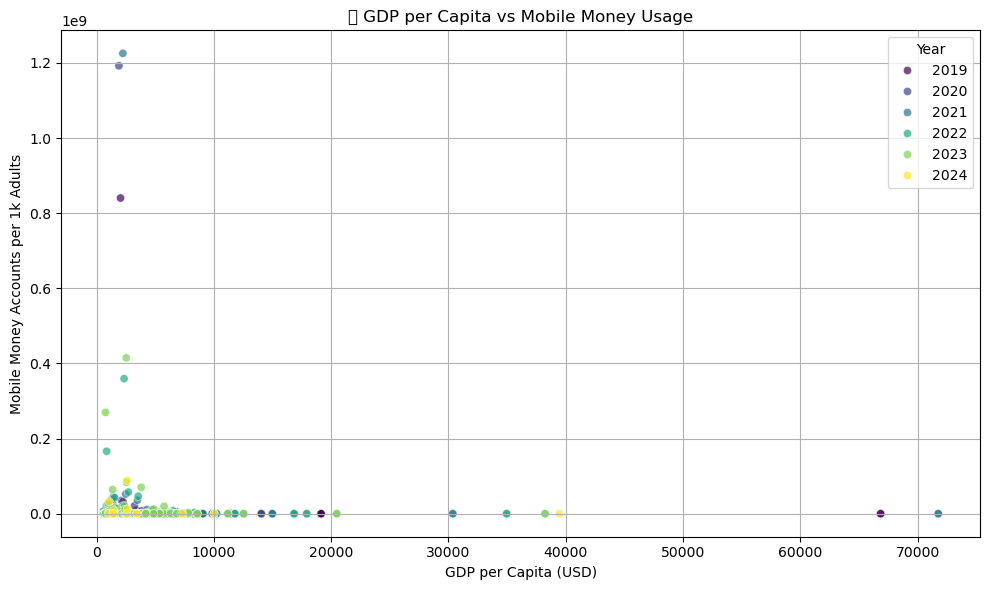

In [323]:
# Step 5: Scatter – GDP per Capita vs Mobile Money Usage
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df,
    x="GDP per capita (current US$)",
    y="Mobile Money Accounts per 1k Adults",
    hue="Year",
    palette="viridis",
    alpha=0.7
)
plt.title("💰 GDP per Capita vs Mobile Money Usage")
plt.xlabel("GDP per Capita (USD)")
plt.ylabel("Mobile Money Accounts per 1k Adults")
plt.grid(True)
plt.tight_layout()
plt.show()

In [324]:
# Step 6: Filter 2021 only (for Unbanked data)
df_2021 = df[df["Year"] == "2021"].copy()

/var/folders/w2/xzx9cghx6_d87gb1m8mhzgth0000gn/T/ipykernel_68504/832598199.py:12: UserWarning: Glyph 129518 (\N{ABACUS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Users/ebmac/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 129518 (\N{ABACUS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


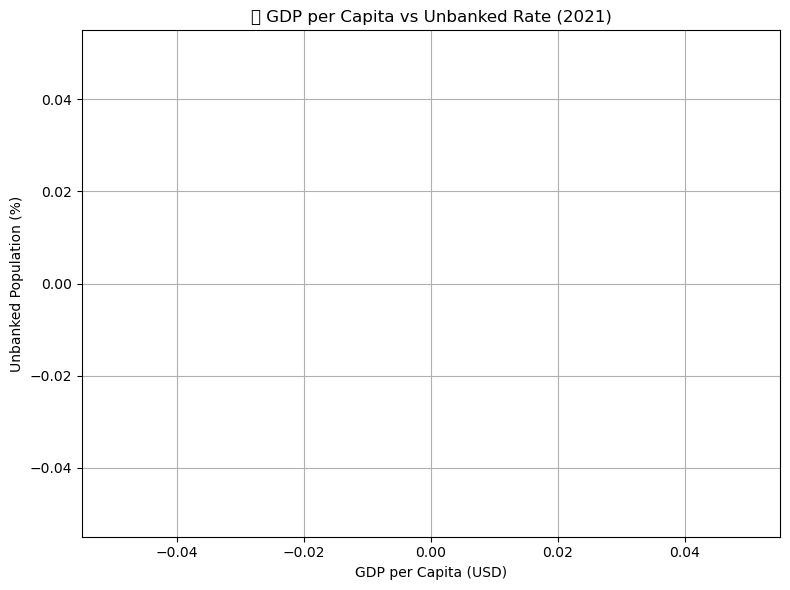

In [325]:
# Step 7: Scatter – GDP vs Unbanked
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=df_2021,
    x="GDP per capita (current US$)",
    y="Unbanked (%)"
)
plt.title("🧮 GDP per Capita vs Unbanked Rate (2021)")
plt.xlabel("GDP per Capita (USD)")
plt.ylabel("Unbanked Population (%)")
plt.grid(True)
plt.tight_layout()
plt.show()

/Users/ebmac/anaconda3/lib/python3.11/site-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/Users/ebmac/anaconda3/lib/python3.11/site-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)
/var/folders/w2/xzx9cghx6_d87gb1m8mhzgth0000gn/T/ipykernel_68504/1999191496.py:14: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Users/ebmac/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


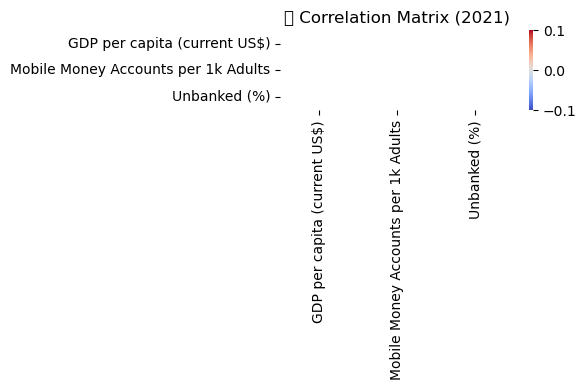

In [326]:
# Step 8: Correlation heatmap (for 2021)
numeric_cols = [
    "GDP per capita (current US$)",
    "Mobile Money Accounts per 1k Adults",
    "Unbanked (%)"
]

# Drop missing rows just in case
corr_matrix = df_2021[numeric_cols].dropna().corr()

plt.figure(figsize=(6, 4))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("📊 Correlation Matrix (2021)")
plt.tight_layout()
plt.show()

#### Plot Mobile Money Usage Over Time for Selected Countries

/var/folders/w2/xzx9cghx6_d87gb1m8mhzgth0000gn/T/ipykernel_68504/1192539165.py:32: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Users/ebmac/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


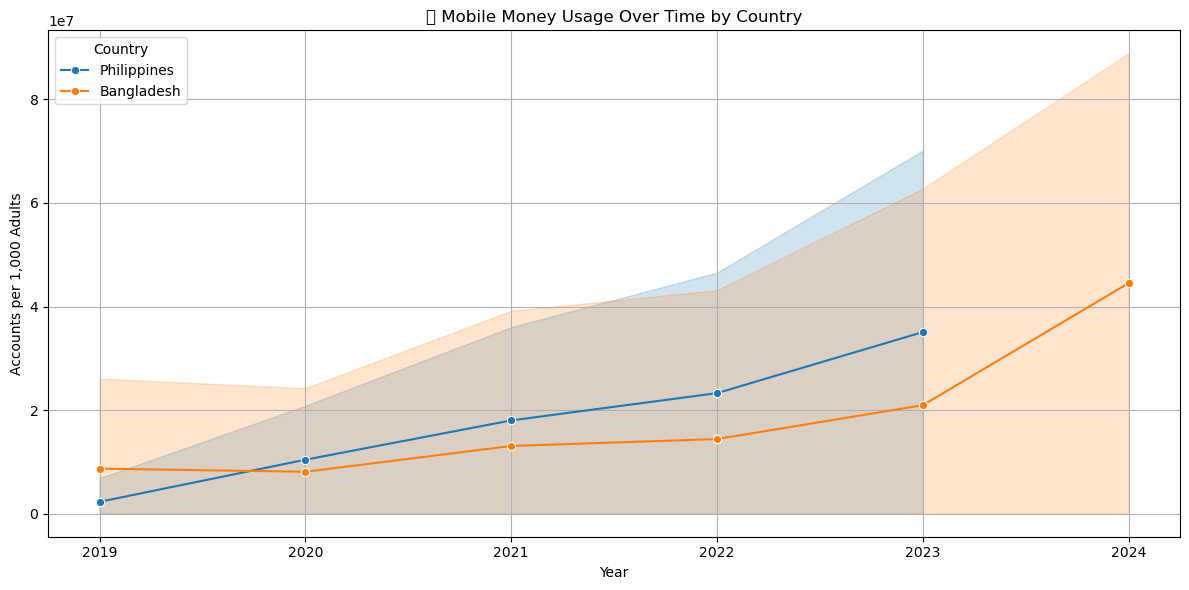

In [327]:
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Filter countries of interest
selected_countries = ["Kenya", "Bangladesh", "Nigeria", "Philippines"]
df_selected = df_plot[df_plot["Country name"].isin(selected_countries)].copy()

# Step 2: Ensure correct types
df_selected["Year"] = df_selected["Year"].astype(str)
df_selected["Mobile Money Accounts per 1k Adults"] = pd.to_numeric(
    df_selected["Mobile Money Accounts per 1k Adults"], errors='coerce'
)

# Step 3: Drop missing values
df_selected = df_selected.dropna(subset=["Mobile Money Accounts per 1k Adults"])

# Step 4: Plot
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=df_selected,
    x="Year",
    y="Mobile Money Accounts per 1k Adults",
    hue="Country name",
    marker="o"
)

plt.title("📊 Mobile Money Usage Over Time by Country")
plt.xlabel("Year")
plt.ylabel("Accounts per 1,000 Adults")
plt.legend(title="Country")
plt.grid(True)
plt.tight_layout()
plt.show()

In [328]:
df_plot["Country name"].unique()

array(['Indonesia', 'Togo', 'Senegal', 'Philippines', 'Ghana', 'Guinea',
       'Zimbabwe', 'Myanmar', 'Mali', 'Burkina Faso', 'Liberia',
       'Pakistan', 'Cameroon', 'Benin', 'Bangladesh', 'Malawi',
       'Mauritius', 'Albania', 'Nicaragua', 'Uganda', 'Iraq', 'Cambodia',
       'Paraguay', 'India', 'Thailand', 'Jamaica', 'Nepal', 'Zambia',
       'Namibia', 'South Africa', 'El Salvador', 'West Bank and Gaza',
       'Honduras', 'Sierra Leone'], dtype=object)

In [329]:
df_plot = df.dropna(subset=["Mobile Money Accounts per 1k Adults", "Country name", "Year"])

In [330]:
df_plot["Country name"].unique()

array(['Indonesia', 'Togo', 'Senegal', 'Philippines', 'Ghana', 'Guinea',
       'Zimbabwe', 'Myanmar', 'Mali', 'Burkina Faso', 'Liberia',
       'Pakistan', 'Cameroon', 'Benin', 'Bangladesh', 'Malawi',
       'Mauritius', 'Albania', 'Nicaragua', 'Uganda', 'Iraq', 'Cambodia',
       'Paraguay', 'India', 'Thailand', 'Jamaica', 'Nepal', 'Zambia',
       'Namibia', 'South Africa', 'El Salvador', 'West Bank and Gaza',
       'Honduras', 'Sierra Leone'], dtype=object)